<a href="https://colab.research.google.com/github/saapo-ka-baadshah/my_uni_work/blob/sem_2%2FDL/assignment1-b-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning programming I-B: Age Regression
Felix Wiewel, Institute of Signal Processing and System Theory, University of Stuttgart, 08.02.2021

## GPU support
In order to speed up calculations with Tensorflow, we need to change the runtime type of this notebook to GPU. For this click on "Runtime" in the top left menu and select "Change runtime type". Then choose "GPU" in the drop down list under "Hardware accelerator". This will enable Tensorflow to execute calculations on a GPU provided by Google Colab.

## Data Set
Before we can use the data set, we have to download it. This is done with the following commands.

In [ ]:
!mkdir data
!gdown https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
!mv UTKFace.tar.gz data

mkdir: cannot create directory ‘data’: File exists
Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /content/UTKFace.tar.gz
107MB [00:00, 109MB/s]


With these commands we created a folder named "data" and downloaded the data set into it. The data set is contained in an archive, which needs to be extracted before we can work with it. Since we will need to load individual images in the coming exercise, it makes sense to first extract the data and then retreive a list with all extracted files. For this we first import all necessary packages and then define a function, which extracts the data and returns a list with all available file names and since the labels are encoded in the file names we directly extract a corresponding list of labels.

In [ ]:
import tarfile
import os
import glob
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
import numpy as np

def load_file_names():
    # Check if data has been extracted and if not extract it
    if (os.path.isdir("/content/data/UTKFace")):
        print("Data set already extracted...")
    else:
        print("Extracting data set...")
        tar = tarfile.open("/content/data/UTKFace.tar.gz")
        tar.extractall("./data")
        tar.close()

    # Get a list of all files in data set
    files = glob.glob("./data/UTKFace/*.jpg")
    labels = [int(f_name.split("/")[-1].split("_")[0]) for f_name in files]
    return files, labels

We can now use this function to plot an individual image and the age of the person in that image..

Data set already extracted...
(200, 200, 3)


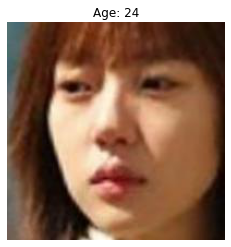

In [ ]:
files, labels = load_file_names()
img = plt.imread(files[0])
print(img.shape)
plt.imshow(img)
plt.title("Age: {}".format(labels[0]))
plt.axis("off")
plt.show()

We should also check the distribution of the labels. For this we will print the unique labels contained in our data set.

In [ ]:
print(np.unique(labels))

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  95  96  99 100 101 103 105 110 111 115 116]


As we can see, the data set contains only integer values as the age label. With such a distribution of labels you could also try to solve the problem of mapping an input image to an age by classifiaction. This is a valid approach but not the one we are interested in. We want to take an image of a person and regress his or her age exactly. Since the potraits in our training data set were certainly not taken in the exact moment that person's age was exactly an integer, we can conclude that the labeling is not well suited for our problem. But since these are the only labels we get for this data set, we have to use them and accept the slightly incorrect labels. We can also think of this discrepancy between the exact age of the person when the photo was taken and the assigned label as noise, i.e. we are given noisy labels.

Now your task is to define a suitable model architecture for the regression of a scalar value like the age of a person from an image.

In [ ]:
""" Implement a small CNN with two convolutional and three dense layers. The conv. layers should have 8 and 16 filters of size 5x5, a stride of 4 and a ReLU activation. Also create a flatten layer and a dropout layer 
with 0.2 droprate. The dense layers should have 128, 64 and 1 neurons and again a ReLU activation. For implementing the layers use predefined layer classes of Keras, e.g. k.layers.Conv2D or k.layers.Dense. 
Hint: Create the layer objects in the constructor and call them in the right order for implementing the forward pass. You need to pass the "training" argument to the dropout layer in order to activate dropout during 
training and deactivate it during testing. """

class MyModel(k.Model):
    def __init__(self):
        # Create layers
        super(MyModel, self).__init__()
        self.conv0 = tf.keras.layers.Conv2D(filters = 8, kernel_size=5, strides=4, activation=tf.nn.relu, padding='SAME', input_shape=(200,200,3), dtype='float32')
        self.conv1 = tf.keras.layers.Conv2D(filters = 16, kernel_size=5, strides=4, activation=tf.nn.relu, padding='SAME', dtype='float32')
        self.flatten = tf.keras.layers.Flatten(dtype='float32')
        self.dropout = tf.keras.layers.Dropout(0.2, dtype='float32')
        self.dense0 = tf.keras.layers.Dense(128, activation='relu', dtype='float32')
        self.dense1 = tf.keras.layers.Dense(64, activation='relu', dtype='float32')
        self.dense2 = tf.keras.layers.Dense(1, activation='relu', dtype='float32')

    def call(self, inputs, training=False):
        # Implement forward pass
        output = self.conv0(inputs)
        output = self.conv1(output)
        output = self.flatten(output)
        if(training): output = self.dropout(output, training=training)
        output = self.dense0(output)
        output = self.dense1(output)
        output = self.dense2(output)
        return output

Notice that in the previous part we defined a \__call__ function and now define a call function. This call function is required by Keras but we can still predict with the model just by calling it on an input tensor. For training the model we again need to define some hyperparameters.

In [ ]:
N_epochs = 20
learning_rate = 0.001
batch_size = 64
N_training_examples = 20000
N_validation_examples = 4*batch_size

N_parallel_iterations = 4
N_prefetch = 8
N_shuffle_buffer = 20000

We will train the model for $20$ epochs with a batch size of $64$ and a learning rate of $0.001$.  We will use $20000$ examples for training $4$ batches for validation and the remaining data for testing of the model. We also define some parameters, which are used to create the Dataset objects. With these definitions we can build the data set objects used for training, validation and testing.

In [ ]:
""" Since we only have the file name and labels of the images, we need to actually load an image into system memory if it is needed. For this we will define a function that parses the image, normalizes it and reshapes 
the label. This reshaping is a technical detail that avoids unintended behaivior during the calculation of the loss, i.e. it avoids unintended broadcasting. Your task is to fill in the missing code for loading, 
decoding and normalizing the image. In this example we normalize the image to pixels in the range between 0 and 1. Hint: For reading and decoding the image use the functions defined in tf.io. The images are stored in the
JPEG format."""

def parse_func(filename, label):
    image_string = tf.io.read_file(filename=filename) # Read the image
    image_decoded = tf.image.decode_jpeg(image_string) # Decode the image
    # image = (tf.image.per_image_standardization(image=image_decoded)) # Normalize the image
    image = tf.cast(image_decoded, tf.float32)/255
    label = tf.expand_dims(tf.cast(label, tf.float32), axis=-1)
    print(type(image))
    return image, label

""" We now build a tensorflow Dataset object that shuffles the data with a shuffle buffer of size "N_shuffle_buffer", applies the parse_func via the .map() function with "N_parallel_iterations", creates batches 
of size "batch_size" and prefetches with "N_prefetch". Please fill in the missing code. """
  
def build_dataset(files, labels, batch_size):
    # Create tf data set
    ds = tf.data.Dataset.from_tensor_slices((files, labels)) # Create data set of files and labels
    ds = ds.shuffle(100, reshuffle_each_iteration=True).repeat() # Enable shuffling
    # print((ds[0]))
    ds = ds.map(parse_func, num_parallel_calls=N_parallel_iterations, deterministic=None)# Apply parse_func
    ds = ds.batch(batch_size).prefetch(N_prefetch) # Batch and prefetch
    return ds

# Shuffle data and labels
train_ds = build_dataset(files[0:N_training_examples],
                                     labels[0:N_training_examples], batch_size)
validation_ds = build_dataset(files[N_training_examples:N_training_examples+N_validation_examples],
                                          labels[N_training_examples:N_training_examples+N_validation_examples],
                                          batch_size)
test_ds = build_dataset(files[N_training_examples+N_validation_examples:],
                                    labels[N_training_examples+N_validation_examples:], batch_size)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


Since the we loaded the file names of individual images and their corresponding labels, we need to load the actual image given its filename. For this we use the map function of the Dataset class. This function applies a function, in our case the parse_func function, to every sample in a batch. The parse_func function then reads the actual image given its name, decodes and normalizes it. It also makes sure that we use the correct dimensions and data types. With the build_dataset function we can then build a Dataset obejct, which first shuffles then applies the parse_func function and finnaly batches the data. In order to iterate many times over the data set, we repeat this process indefenetly.

In order to train the model, we again use a function which does one training step. This function is similar to the previous part of this exercise with the addition of the @tf.function decorator, which tells Tensorflow to build this function as a graph in order to speed up repeated calls to it. We also use the mean absolute error (MAE) as a loss for training the model. This loss can be derived in the same way as in the previous part if we assume laplacian distributed noise in out signal model.

In [ ]:
""" For this application we will use the Mean Absolute Error (MAE) as a loss function for training. Please implement the loss and the training step."""

# Define loss function
def loss(y, y_pred):
    return tf.reduce_mean(tf.abs(y - tf.reshape(y_pred, y.shape))) # MAE between "y" and "y_pred"

# Define training step as a complete graph
@tf.function
def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        y_pred = model(x)# Predict with model on "x"
        loss_val = loss(y, y_pred) # Compute the loss with "y" and "y_pred"
    grads = tape.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_val

Now we just need to instantiate an instance of our model and an optimizer in order to start training. We also build the model in order to be able to print it's summary.

In [ ]:
mdl = MyModel()
opt = tf.optimizers.RMSprop(learning_rate)
mdl.build(input_shape=(batch_size, 200, 200, 3))
mdl.summary()

Model: "my_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           multiple                  608       
_________________________________________________________________
conv2d_11 (Conv2D)           multiple                  3216      
_________________________________________________________________
flatten_5 (Flatten)          multiple                  0         
_________________________________________________________________
dropout_5 (Dropout)          multiple                  0 (unused)
_________________________________________________________________
dense_15 (Dense)             multiple                  346240    
_________________________________________________________________
dense_16 (Dense)             multiple                  8256      
_________________________________________________________________
dense_17 (Dense)             multiple                  6

We use a similar loop as in the previous part of this exercise for training.

In [ ]:
# Run training
epoch = 0
train_loss = 0.0
train_iters = 0
for train_images, train_labels in train_ds:
    train_loss += train_step(mdl, opt, train_images, train_labels) # Perform a train step
    train_iters += 1
    if (train_iters + 1 == int(N_training_examples/batch_size)):# An epoch is completed
        epoch += 1
        val_loss = 0.0
        val_iters = 0
        for val_images, val_labels in validation_ds:
            y_pred = mdl(val_images) # Predict on validation images
            loss_val = loss(y=val_labels, y_pred=y_pred) # Compute loss for validation
            val_loss += loss_val
            val_iters += 1
            if val_iters == int(N_validation_examples/batch_size):
                print("Epoch: {} Training loss: {:.5} Validation loss {:.5}"
                      .format(epoch, train_loss/train_iters, val_loss/val_iters))
                break
        train_loss = 0.0
        train_iters = 0
    if epoch == N_epochs:
        break

Epoch: 1 Training loss: 15.757 Validation loss 13.822
Epoch: 2 Training loss: 12.662 Validation loss 12.302
Epoch: 3 Training loss: 10.837 Validation loss 10.714
Epoch: 4 Training loss: 9.8925 Validation loss 11.087
Epoch: 5 Training loss: 9.3022 Validation loss 12.254
Epoch: 6 Training loss: 8.9388 Validation loss 9.1207
Epoch: 7 Training loss: 8.5566 Validation loss 9.7967
Epoch: 8 Training loss: 8.3137 Validation loss 8.52
Epoch: 9 Training loss: 7.9794 Validation loss 9.7388
Epoch: 10 Training loss: 7.7694 Validation loss 8.1967
Epoch: 11 Training loss: 7.5983 Validation loss 7.9441
Epoch: 12 Training loss: 7.3741 Validation loss 8.8349
Epoch: 13 Training loss: 7.1747 Validation loss 8.6303
Epoch: 14 Training loss: 7.0118 Validation loss 7.9888
Epoch: 15 Training loss: 6.8749 Validation loss 8.0214
Epoch: 16 Training loss: 6.7328 Validation loss 8.7219
Epoch: 17 Training loss: 6.5673 Validation loss 7.8324
Epoch: 18 Training loss: 6.4156 Validation loss 8.0533
Epoch: 19 Training lo

Testing the model on the test data set is also similar to the previous part of this exercise.

In [ ]:
# Test model
Num_test_batches = int((len(files)-N_validation_examples-N_validation_examples)/batch_size)
test_loss = 0.0
test_iters = 0
for test_images, test_labels in test_ds:
    y_pred = mdl(test_images) # Predict on test images
    test_loss += loss(test_labels, y_pred) # Compute test loss
    test_iters += 1
    if test_iters == Num_test_batches:
        print("Test loss: {:.5}".format(test_loss/test_iters))
        break

Test loss: 7.1441


We again can compare the training, validation and test losses in order to verify if our model is overfitting or not. We can now also upload our own images and predict on them. For this we need to upload an image which contains a quadratic potrait with the face aligned in the center.

In [ ]:
# from google.colab import files
# uploaded = files.upload()
# fn = list(uploaded.keys())[0]
fn = "Photo.jpg"
  

Now we do a prediction  and plot the result.

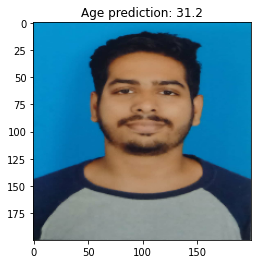

In [ ]:
""" For predicting on the uploaded image, open and decode it using tf.io. After that we also need to normalize and resize it using tf.image.resize. Hint: For predicting with our model we need to add a batch dimension
of 1, since we effectively feed our model with a batch containing only one image."""


# Load and predict on an image
image_string = tf.io.read_file(filename=fn) # Load image with path "fn"
image_decoded = tf.image.decode_jpeg(image_string, channels=3) # Decode the image and add a batch dimension
image = tf.reshape(tf.cast(tf.image.resize(image_decoded, size=(200,200)), tf.float32)/255, (1,200,200,3)) # Normalize, resize to 200x200 pixels and cast image to tf.float32
age = mdl(image)

# Plot image and prediction
plt.imshow(np.squeeze(image.numpy()))
plt.title("Age prediction: {:.3}".format(np.squeeze(age.numpy())))
plt.show()

## Conclusion
In this part of the exercise we have applied the concept of regression to the problem of estimating the age of a person from his or her potrait. In this process we have seen how to load images from their filenames with the map function of the Dataset class. With this, images are loaded just in time as they are needed, which is beneficial if you are working with a large number of high resolution images that do not fit into your system memory all at once. We also used Keras in order to build our model from predefined layers. If the layers you need for building your model are available through Keras, it is highly recommended to use those in order to speed up develpment time and reduce possible error sources. We also observed that the labeling of the individual images is not optimal for our task, since it is rounded to integer ages and in the setting of regression we would rather like to have continuous age labels.

## Task 1 : Solution ##
---
Here I have specified the `padding = "SAME"` in the convolutional layer so the image size will remain the same while the `stride = 4` will downsample the convolution image.

Hence, the 200px X 200px image when convolved with 5px X 5px kernel with stride of 4 will give image size = 
$$ceiling(\frac{200}{4}) \times ceiling(\frac{200}{4}) = 50\times50$$

If we do not use the `padding`, in that case the answer comes out to be 
$$49\times49$$


For this problem, I will stick with the padding since it simplifies the calculatinos further.

Hence the convolution image domain and dimensions after the layer `self.conv0` are 
$$\mathbb{R}^{50\times50\times8}$$

Hence the convolution image domain and dimensions after the layer `self.conv1` are 
$$\mathbb{R}^{13\times13\times16}$$

Hence the `self.flatten` layer will have in total 2704 neurons


Tensor              | Should be in $$\in$$     
--------------------|-----------------------
input: $$\underline{x}$$   | $$\mathbb{R}^{200\times200\times3}$$
`self.conv0` : $$\underline{\underline{K_{0}}}$$   | $$\mathbb{R}^{5\times5\times3\times8}$$
`self.conv1` : $$\underline{\underline{K_{1}}}$$   | $$\mathbb{R}^{5\times5\times8\times16}$$
`self.flatten` : $$\underline{\underline{F}}$$   | $$\mathbb{R}^{2704}$$

Here the Dropout layer will drop random 20% neurons from the flatten output reducing the dimensionality of the after dropout to 2164.

Hence the dense layers will look something like: 

Tensor              | Should be in $$\in$$     | Weights $$W_{i}\in$$    | Biases $$b_i\in$$
--------------------|-----------------------|---------------------------|-------------------
`self.dense0` : $$\underline{\underline{D_{0}}}$$   | $$\mathbb{R}^{2164\times128}$$ | $$\mathbb{R}^{2164\times128}$$ | $$\mathbb{R}^{128}$$
`self.dense1` : $$\underline{\underline{D_{1}}}$$   | $$\mathbb{R}^{128\times64}$$ | $$\mathbb{R}^{128\times64}$$ | $$\mathbb{R}^{64}$$
`self.dense2` : $$\underline{\underline{D_{2}}}$$   | $$\mathbb{R}^{64\times1}$$ | $$\mathbb{R}^{64\times1}$$ | $$\mathbb{R}^{1}$$

## Task2 : Solution : Feasibility of ReLU and Linear ##
---

In the problem of the Age Regression we are looking at an output of the model in $$X_{L}\in\{\mathbb{R}^{1}\land[0, \infty]\} $$

This can be achieved by the ReLU activation function since it operates in the real domain with the range of $$[0, \infty]$$

---

This is the exact reason for not using the Linear activation function. Since by Usage of no activation in the output layer, the results would be interpreted in $$X_{L}\in\{\mathbb{R}^{1}\land[-\infty, \infty]\} $$ which is counterintuitive for the Age Regression problem.

## Task 3 : Solution : Age estimation as a classification problem ##
---

### Against: ###
- As a classification problem, we will have the output in a discrete fashion. The **age** being a continuous mathematical variable, the idea of discrete interpretation will lose the resolution. z.B. `floor(1.729) == 1` loses resolution of the value.
- In order to achieve the classification, one would need some preprocessing in ourder to get the range of the age labels. One would need to create N<sub>L</sub> neurons for N<sub>L</sub> total age label classes. This would increase the number of parameters being calculated. The increase in the number of parameters can be given by : $$(N_{L} - 1).(D_{L-1} + 1)$$
where , **D<sub>L-1</sub> = X<sub>L-1</sub> layer neuron count** AND **N<sub>L</sub>=X<sub>L</sub> layer neuron count**
- This will also need one hot encoding, which can be a computationally complex task for large values of samples.

---
### For: ###
- Will provide a probabilistic output with the use of **softmax** output function.
- With **categorical crossentropy**, the loss calculations may feel very intuitive.